<a href="https://colab.research.google.com/github/IgorQuaresma/SirioLibanesKaggle/blob/main/Notebooks/Bootcamp_PF_MachineLearningModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Machine Learning

## Introduction

This notebook is the part 3 of 3 notebooks that composes the whole project. The notebook is going to use the data from the pre-proccessing step (part 1) and insights from the exploratory analysis that was done in part 2.

## Importing the libs

In [1]:
#!pip install yellowbrick

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import transforms
import numpy as np
import seaborn as sns
import sklearn as skl

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestCentroid
from yellowbrick.features import FeatureImportances 

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Functions

In [3]:
def separate_train_test(data):
  '''separates the train and test data '''
  np.random.seed(1234525)
  x_columns = data.columns 
  y = data['ICU']
  x = data[x_columns].drop(['ICU','WINDOW'],axis=1)
  x_train,x_test,y_train,y_test = train_test_split(x, y, stratify = y, test_size=0.2)
  return x_train,x_test,y_train,y_test

In [4]:
def accuracy(data, model, name):
  '''returns the value of accuracy'''
  model = model
  x_train,x_test,y_train,y_test = separate_train_test(data)
  model.fit(x_train,y_train)
  predict = model.predict(x_test)

  print(f'The accuracy of the {name} model is: {(accuracy_score(y_test, predict))*100 :.2f}% ')

In [5]:
def run_model(data, model):
  '''Returns the Classication Report with the following metrics: recall,f1-score e support'''
  #separating train and test data
  x_train, x_test, y_train, y_test = separate_train_test(data)

  #creating the model
  model.fit(x_train,y_train)
  predict = model.predict(x_test)
  proba_predict = model.predict_proba(x_test)
  
  #return the auc
  auc = roc_auc_score(y_test,proba_predict[:,1])
  print(f'AUC = {auc}')
  print("\nClassification Report")
  print(classification_report(y_test, predict))

In [6]:
def run_model_cv(model, data, n_splits, n_repeats):
  '''Returns the mean test and mean train auc of an specific model'''
  #separating train and test data
  np.random.seed(1234525) 
  data = data.sample(frac = 1).reset_index(drop = True) 
  x_columns = data.columns 
  y = data['ICU']
  x = data[x_columns].drop(['ICU','WINDOW'], axis=1)

  #creating the model
  cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats=n_repeats)
  results = cross_validate(model,x,y,cv=cv,scoring = 'roc_auc', return_train_score=True) 

  #return the auc
  mean_auc = np.mean(results['test_score']) 
  mean_auc_train = np.mean(results['train_score']) 
  auc_std = np.std(results['test_score'])
  print(f'AUC TEST = {mean_auc} --- AUC TRAIN = {mean_auc_train}')
  return mean_auc, mean_auc_train

In [7]:
def decision_tree_model(data, criterion , max_depth, splitter):
  '''Returns the decision tree model results'''
  #Creating the model
  model = DecisionTreeClassifier(criterion = criterion, max_depth = max_depth, splitter=splitter )
  
  #separating train and test data
  x_train,x_test,y_train,y_test = separate_train_test(data)
  model.fit(x_train,y_train)
  
  #Criando a predição
  predict = model.predict(x_test)
  
  return model, predict

In [8]:
def logistic_regression_model(data, penalty, c, solver, max_iter, multi_class):
  '''Returns the logistic regression model results'''
  #Creating the model
  model = LogisticRegression(penalty=penalty, C=c, solver=solver, max_iter=max_iter, multi_class=multi_class)
  
  #separating train and test data
  x_train,x_test,y_train,y_test = separate_train_test(data)
  model.fit(x_train,y_train)
  
  #Predicting
  predict = model.predict(x_test)
  
  return model, predict

In [9]:
def random_forest_model(data, n_est, max_feat, max_depth, bootstrap, oob_score, criterion, min_samples_leaf, min_impurity_decrease):
  '''Returns therandom forest model results'''
  #Creating the model
  model = RandomForestClassifier(n_estimators=n_est, 
                                 max_features=max_feat,
                                 max_depth=max_depth, 
                                 bootstrap=bootstrap,
                                 oob_score=oob_score, 
                                 criterion=criterion, 
                                 min_samples_leaf=min_samples_leaf,
                                 min_impurity_decrease=min_impurity_decrease)
 
  #separating train and test data
  x_train,x_test,y_train,y_test = separate_train_test(data)
  model.fit(x_train,y_train)
 
  #Predicting
  predict = model.predict(x_test)
  
  return model, predict

In [10]:
def roc_plot(model, model_name, data):
  '''Plots the roc curve'''
  
  #divide data
  x_train, x_test, y_train, y_test = separate_train_test(data)
  
  #create figure
  fig = plt.subplots(figsize=(10, 10))
  ax = plt.axes()

  #plot the curve
  plot_roc_curve(model, x_test, y_test, ax=ax, color='r')

  #define labels and title
  plt.title(f'ROC curve for the {model_name} model \n', fontsize=20, fontweight='bold',
           color='black')
  plt.ylabel('(VP)', fontsize=11, color='dimgrey',
             fontweight='bold')
  plt.xlabel('(FP)', fontsize=11, color='dimgrey',
             fontweight='bold')

  
  ax.spines['bottom'].set_color('silver')
  ax.spines['left'].set_color('silver')
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)

  # create the grid
  ax.grid(axis='both', which='major', linestyle='dotted')

  # insert legend
  ax.legend(loc='upper left', fontsize=10)

  plt.show()

In [11]:
def confusion_matrix_plot(model, model_name, data):
  '''plot the confusion matrix of a specific model'''
  
  # divide data
  x_train, x_test, y_train, y_test = separate_train_test(data)

  # create figure
  fig = plt.figure(figsize=(10, 10))
  ax = plt.axes()

  # plot matrix
  plot_confusion_matrix(model, x_test, y_test, ax = ax, normalize='true',
                        display_labels=['NO ICU support', 'ICU support'])
  
  # remove colorbar
  fig.delaxes(fig.axes[1])
  
  # define labels and title
  plt.title(f'Confusion Matrix of the  {model_name} model \n', fontsize=20, fontweight='bold',
           color='black')
  plt.ylabel('Actual Class', fontsize=11, color='dimgrey',
             fontweight='bold')
  plt.xlabel('Predicted Class', fontsize=11, color='dimgrey',
             fontweight='bold')
  
  plt.show()

In [12]:
def grid_search_cv(parameters, model, data):
  
  #split the data in train and test data
  x_train,x_test,y_train,y_test = separate_train_test(data)
  
  #create the grid search
  modelo_grid = GridSearchCV(model, param_grid=parameters, cv=5, scoring="roc_auc")

  #train the model
  modelo_grid.fit(x_train,y_train)

  #generate the best paramaters for each model
  best_params = modelo_grid.best_params_

  return best_params

##1. Machine learning Models

In this section the data and insights from the previous notebooks are going to be used to make a prediction model. First, the information need to be put into a specific format, since the models demands the input of data on a specific way.

In [13]:
#Reading the data
data = pd.read_csv('https://raw.githubusercontent.com/IgorQuaresma/SirioLibanesKaggle/main/Data/Processed/processed_data_ml.csv')
data = data.iloc[:,3:]
data.head()

,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_DIFF,CREATININ_MEDIAN,CREATININ_DIFF,FFA_MEDIAN,FFA_DIFF,GGT_MEDIAN,GGT_DIFF,GLUCOSE_MEDIAN,GLUCOSE_DIFF,HEMATOCRITE_MEDIAN,HEMATOCRITE_DIFF,HEMOGLOBIN_DIFF,INR_MEDIAN,...,PH_ARTERIAL_DIFF,PH_VENOUS_MEDIAN,PH_VENOUS_DIFF,PLATELETS_MEDIAN,PLATELETS_DIFF,POTASSIUM_MEDIAN,POTASSIUM_DIFF,SAT02_ARTERIAL_MEDIAN,SAT02_ARTERIAL_DIFF,SAT02_VENOUS_MEDIAN,SAT02_VENOUS_DIFF,SODIUM_MEDIAN,SODIUM_DIFF,TGO_MEDIAN,TGO_DIFF,TGP_MEDIAN,TGP_DIFF,TTPA_MEDIAN,TTPA_DIFF,UREA_MEDIAN,UREA_DIFF,DIMER_MEDIAN,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,RESPIRATORY_RATE_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,HEART_RATE_DIFF_REL,WINDOW,ICU
0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.938950,-1.0,-1.0,-1.0,0.183673,-1.0,-0.868365,-1.0,-0.742004,-1.0,-0.945093,-1.0,-0.891993,-1.0,0.090147,-1.0,-1.0,-0.932246,...,-1.0,0.363636,-1.0,-0.540721,-1.0,-0.518519,-1.0,0.939394,-1.0,0.345679,-1.0,-0.028571,-1.0,-0.997201,-1.0,-0.990854,-1.0,-0.825613,-1.0,-0.836145,-1.0,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,-0.500000,-0.247863,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.938950,-1.0,-1.0,-1.0,0.357143,-1.0,-0.912243,-1.0,-0.742004,-1.0,-0.958528,-1.0,-0.780261,-1.0,0.144654,-1.0,-1.0,-0.959849,...,-1.0,0.363636,-1.0,-0.399199,-1.0,-0.703704,-1.0,0.939394,-1.0,0.345679,-1.0,0.085714,-1.0,-0.995428,-1.0,-0.986662,-1.0,-0.846633,-1.0,-0.836145,-1.0,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.714286,-0.435897,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.747001,0-2,1
2,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.972789,-1.0,-1.0,-1.0,0.326531,-1.0,-0.968861,-1.0,-0.194030,-1.0,-0.316589,-1.0,-0.891993,-1.0,-0.203354,-1.0,-1.0,-0.959849,...,-1.0,0.363636,-1.0,-0.564753,-1.0,-0.777778,-1.0,0.939394,-1.0,0.580247,-1.0,0.200000,-1.0,-0.989549,-1.0,-0.956555,-1.0,-0.846633,-1.0,-0.937349,-1.0,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,-0.357143,-0.299145,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
3,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.935113,-1.0,-1.0,-1.0,0.357143,-1.0,-0.913659,-1.0,-0.829424,-1.0,-0.938084,-1.0,-0.851024,-1.0,0.358491,-1.0,-1.0,-0.959849,...,-1.0,0.363636,-1.0,-0.457944,-1.0,-0.592593,-1.0,0.939394,-1.0,0.345679,-1.0,0.142857,-1.0,-0.998507,-1.0,-0.991235,-1.0,-0.846633,-1.0,-0.903614,-1.0,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,-0.571429,-0.076923,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,-0.979798,-0.956805,0-2,0
4,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.938950,-1.0,-1.0,-1.0,0.357143,-1.0,-0.891012,-1.0,-0.742004,-1.0,-0.958528,-1.0,-0.891993,-1.0,0.291405,-1.0,-1.0,-0.959849,...,-1.0,0.363636,-1.0,-0.292390,-1.0,-0.666667,-1.0,0.939394,-1.0,0.345679,-1.0,0.085714,-1.0,-0.997947,-1.0,-0.988948,-1.0,-0.846633,-1.0,-0.884337,-1.0,-1.000000,-1.0,-0.037037,-0.538462,-0.537736,-0.525424,-0.196429,0.815789,-0.428571,-0.247863,

In [14]:
#Saving the values in the dependent (y) and independent variable (x)
x = data.drop(['ICU','WINDOW'], axis=1) 
y= data['ICU']

Now that the data is ready, the prediction models using different techniques will be shown below.

In this project the following models are going to be used:

*   Decision Tree
*   Logistic Regression
*   Random Forest



##1.1 Decision Tree Classifier

**Description** - The decision tree is one predictive modelling approach that goes from observations about an item (represented in the branches) to conclusions about the item's target value (represented in the leaves).

We are going to use the following parameters of the model:

*   criterion - The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain

*   splitter: The strategy used to choose the split at each node. Supported strategies are “best” to choose the best split and “random” to choose the best random split.

*   splitter: The maximum depth of the tree.

Since each parameter can receive different values, a test to choose which values are better is going to be used. For this reason, the grid_search_cv function is going to be used. The function will return the best values for each parameter based on the input of a dictionary.  

In [15]:
parameters_DT = {"criterion":['gini','entropy'],
                 "splitter":['best','random'],
                 "max_depth":[1,2,3,4,5] }

test_model_DT = DecisionTreeClassifier()

grid_search_cv(parameters_DT,test_model_DT, data)

{'criterion': 'gini', 'max_depth': 2, 'splitter': 'best'}

Considering the results, the following values are going to be used in the model.

criterion -> entropy

splitter  -> random

max_depth -> 4



In [16]:
#Decision tree model
model_DT, predict_DT = decision_tree_model(data, criterion='entropy' , max_depth=4, splitter='random')

#model accuracy
accuracy(data,model_DT,'Decision Tree')

The accuracy of the Decision Tree model is: 61.97% 


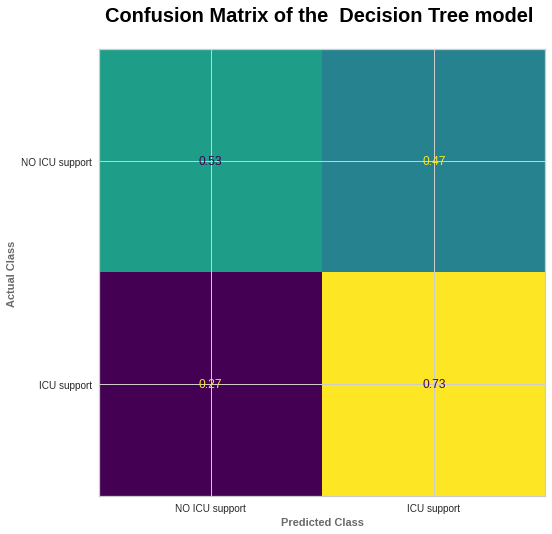

In [17]:
confusion_matrix_plot(model_DT, 'Decision Tree', data)

According to the confusion matrix, we have the following results.

True positive (TP)  -  0.73 patients that really needed to go the the ICU

true negative (TN)  -  0.53 patients patients that didn't need to go to the ICU

False positive (FP) -  0.47 patients didn't need to go, but they went to the ICU

False negative (FN) -  0.27 patients needed to go, but that didn`t go


The decision tree model predicted correctly that 73% of the patients needed to go to the ICU and 53% of the patients didn't need the ICU support. Since this model is being used to predict something related to the lives of people, the values of false negatives (27%) and false positives (27%) are not a good. The values are so high, especially for the FN because having a 27% chance of not giving the ICU support to a patient that actually needs this support is a huge risk for this patient's life.



In [18]:
run_model(data, model_DT)

AUC = 0.6590909090909091

Classification Report
              precision    recall  f1-score   support

           0       0.69      0.53      0.60        38
           1       0.57      0.73      0.64        33

    accuracy                           0.62        71
   macro avg       0.63      0.63      0.62        71
weighted avg       0.63      0.62      0.62        71



To be able to interpret the results, it is necessary to define the concepts of the metrics used in the classification report. This definition will be used through all the models in this project. As Shivam Kohli defines [3],



The classification report presents a summary of different ways to measure the  quality of predictions from a specific classification algorithm. The classification report visualizer displays the precision, recall, F1, and support scores for the model. 


*   Precision is the ability of a classifier not to label an instance positive that is actually negative. For each class, it is defined as the ratio of true positives to the sum of a true positive and false positive.
*  Recall is the ability of a classifier to find all positive instances. For each class it is defined as the ratio of true positives to the sum of true positives and false negatives.
*  The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. F1 scores are lower than accuracy measures as they embed precision and recall into their computation. As a rule of thumb, the weighted average of F1 should be used to compare classifier models, not global accuracy. 


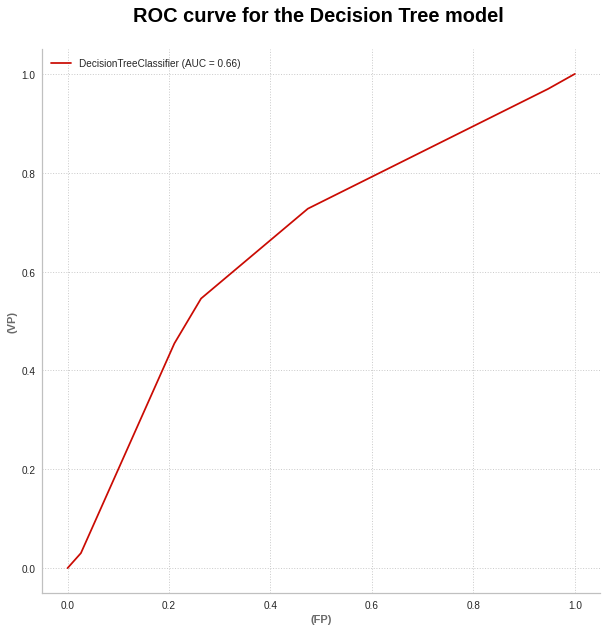

In [19]:
roc_plot(model_DT, 'Decision Tree', data)

In [21]:
run_model_cv(model_DT, data, n_splits=5, n_repeats=10)

AUC TEST = 0.6791793692616062 --- AUC TRAIN = 0.8300472217082724


(0.6791793692616062, 0.8300472217082724)

Finally, the reuslts of the model are 

AUC TEST: 0.68 | AUC TREINO: 0.83




##1.2 Logistic Regression

**Description** - Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable.

We are going to use the following parameters of the model:

*   penalty: Used to specify the norm used in the penalization.

*   C: Inverse of regularization strength; must be a positive float.

*   solver: Algorithm to use in the optimization problem

*   max_iter: Maximum number of iterations taken for the solvers to converge.

*   multi_class: If the option chosen is ‘ovr’, then a binary problem is fit for each label. For ‘multinomial’ the loss minimised is the multinomial loss fit across the entire probability distribution, even when the data is binary. ‘multinomial’ is unavailable when solver=’liblinear’. ‘auto’ selects ‘ovr’ if the data is binary, or if solver=’liblinear’, and otherwise selects ‘multinomial’.

Since each parameter can receive different values, a test to choose which values are better is going to be used. For this reason, the grid_search_cv function is going to be used. The function will return the best values for each parameter based on the input of a dictionary.  


In [ ]:
parameters_LR = {"penalty":['l1','l2','elasticnet','none'],
                 "C":[1.0,2.0,3.0,4.0,5.0,6.0],
                 "solver":['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                 "max_iter":[100,1000,10000,100000],
                 "multi_class":['auto','ovr','multinomial']
                 }

test_model_LR = LogisticRegression()

#grid_search_cv(parameters_LR,test_model_LR, data)

Considering the results, the following values are going to be used in the model.

penalty ->  'l2'

C -> 1.0

solver -> 'newton-cg'

max_iter -> 100

multi_class -> 'auto'



In [22]:
#Logistic Regression model
model_LR,predict_LR=logistic_regression_model(data,penalty='l2',c=1.0, solver='newton-cg', max_iter=100,multi_class='auto')


#model accuracy
accuracy(data,model_LR,'Logistic Regression')

The accuracy of the Logistic Regression model is: 70.42% 


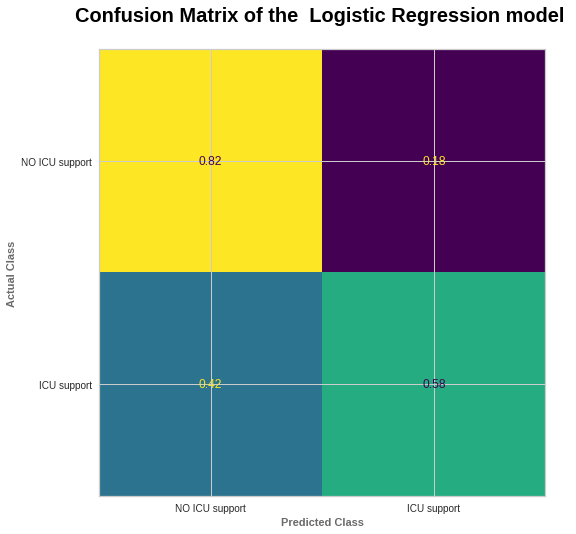

In [23]:
confusion_matrix_plot(model_LR, 'Logistic Regression', data)

According to the confusion matrix, we have the following results.

True positive (TP) - 0.58 patients that really needed to go the the ICU

true negative (TN) - 0.82 patients patients that didn't need to go to the ICU

False positive (FP) - 0.18 patients didn't need to go, but they went to the ICU

False negative (FN) - 0.42 patients needed to go, but that didn`t go

The logistic regression model predicted correctly 82% of patients that didn't need the ICU support. Although this is a great value, the percentage of patients that needed the ICU support and had the treatment was only 58%. 

Just like the decision tree model, the values of FP and FN for the logistic regression were so high, especially for the false negatives. The value of 42% is really serious, because it means that 42% of the patients that actually needed the ICU support were categorized as patientes that didn't need this support.


In [24]:
run_model(data, model_LR)


AUC = 0.7807017543859649

Classification Report
              precision    recall  f1-score   support

           0       0.69      0.82      0.75        38
           1       0.73      0.58      0.64        33

    accuracy                           0.70        71
   macro avg       0.71      0.70      0.70        71
weighted avg       0.71      0.70      0.70        71



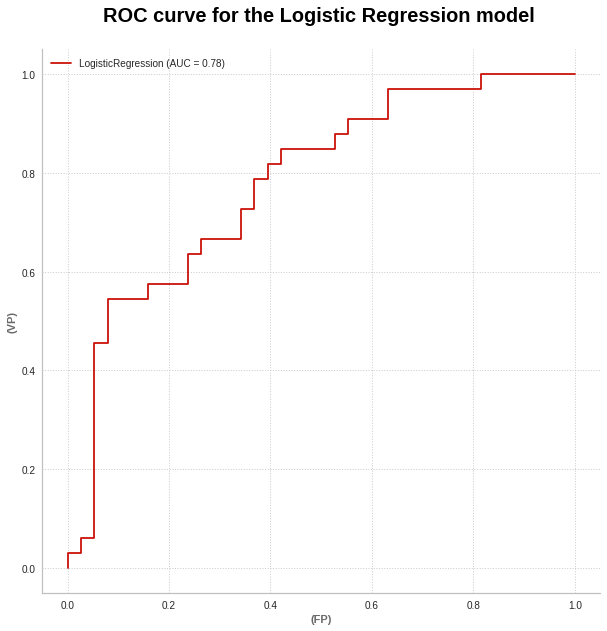

In [25]:
roc_plot(model_LR, 'Logistic Regression', data)

In [26]:
run_model_cv(model_LR, data, n_splits=5, n_repeats=10)


AUC TEST = 0.7731730489460752 --- AUC TRAIN = 0.8492927587446916


(0.7731730489460752, 0.8492927587446916)

##1.3 Random Forest

**Description** - A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

We are going to use the following parameters of the model:

*   n_estimators: The number of trees in the forest

*   criterion: The function to measure the quality of a split.

*   max_depth: The maximum depth of the tree.

*   min_samples_leaf: The minimum number of samples required to be at a leaf node.

*   max_features: The number of features to consider when looking for the best split.

*   min_impurity_decrease: A node will be split if this split induces a decrease of the impurity greater than or equal to this value.

*   bootstrap: Whether bootstrap samples are used when building trees. 

*   oob_score: Whether to use out-of-bag samples to estimate the generalization score. Only available if bootstrap=True.

Since each parameter can receive different values, a test to choose which values are better is going to be used. For this reason, the grid_search_cv function is going to be used. The function will return the best values for each parameter based on the input of a dictionary.  


In [ ]:
parametros_RF = {"n_estimators": [100, 200, 500],
               "max_features": ["auto", "sqrt", "log2"],
               "max_depth": [2, 3, 4, 5, 6],
               "bootstrap": ["True", "False"],
               "oob_score": ["True", "False"],
               "criterion" :["gini", "entropy"],
               "min_samples_leaf":[2,4,6,8,10],
               'min_impurity_decrease':[0.0002,0.0004,0.006,0.008]}

test_model_RF = RandomForestClassifier()

#grid_search_cv(parametros_RF, test_model_RF, data)

Considering the results, the following values are going to be used in the model.

n_estimators ->  200

max_features -> 'auto'

max_depth -> 6

bootstrap -> 'True'

oob_score -> 'False'

criterion -> 'gini'

min_samples_leaf -> 2 

min_impurity_decrease -> 0.0004 



In [27]:
#Decision tree model
model_RF, predict_RF = random_forest_model(data, n_est=200, max_feat='auto', max_depth=6, bootstrap='True', oob_score='False', criterion='gini', min_samples_leaf=2, min_impurity_decrease=0.0004)


#model accuracy
accuracy(data, model_RF,'Random Forest')

The accuracy of the Random Forest model is: 76.06% 


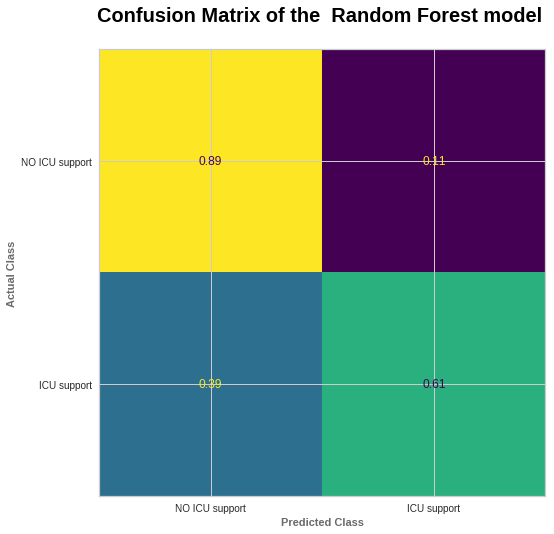

In [28]:
confusion_matrix_plot(model_RF, 'Random Forest', data)

According to the confusion matrix, we have the following results.

True positive (TP) - 0.61 patients that really needed to go the the ICU

true negative (TN) - 0.89 patients patients that didn't need to go to the ICU

False positive (FP) - 0.11 patients didn't need to go, but they went to the ICU

False negative (FN) - 0.39 patients needed to go, but that didn`t go

Just like what happened with the previous models, the value of FN is really high, since the model is being used to predict something is related to peoples lives.

In [29]:
run_model(data, model_RF)

AUC = 0.8110047846889952

Classification Report
              precision    recall  f1-score   support

           0       0.72      0.89      0.80        38
           1       0.83      0.61      0.70        33

    accuracy                           0.76        71
   macro avg       0.78      0.75      0.75        71
weighted avg       0.77      0.76      0.75        71



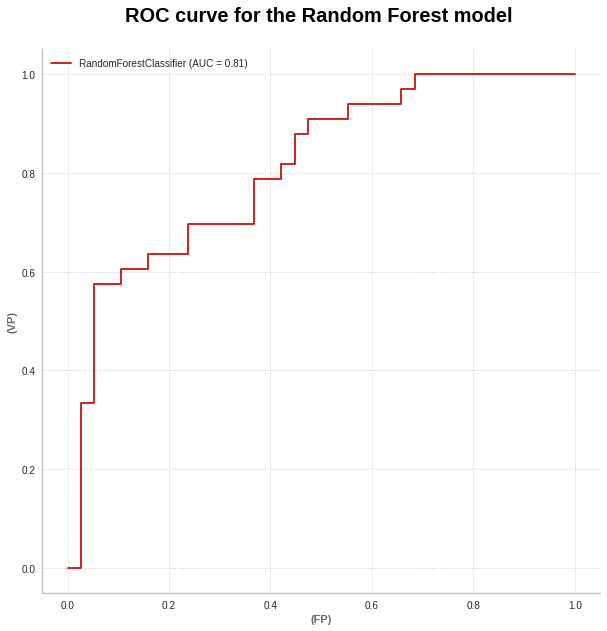

In [30]:
roc_plot(model_RF, 'Random Forest', data)

In [31]:
run_model_cv(model_RF, data, n_splits=5, n_repeats=10)

AUC TEST = 0.8080599513987673 --- AUC TRAIN = 0.9881305414736711


(0.8080599513987673, 0.9881305414736711)

#Conclusion

Considering the models tested in this project, Decision Tree, Logistic Regression, and Random Forest, the best results were obtained with the **Random Forest Model**, which presented the  following values:

```
AUC TEST = 0.8080599513987673 --- AUC TRAIN = 0.9881305414736711
(0.8080599513987673, 0.9881305414736711)

Mean AUC = 0.8110047846889952

Classification Report
              precision    recall  f1-score   support

           0       0.72      0.89      0.80        38
           1       0.83      0.61      0.70        33

    accuracy                           0.76        71
   macro avg       0.78      0.75      0.75        71
weighted avg       0.77      0.76      0.75        71

```

As a complement of this project, a good idea to improve the Random Forest model is trying to reduce the percentage of False Negatives presented in the Confusion Matrix. 


##References


[1] [Confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix)

[2] [Understanding the Classification report through sklearn](https://muthu.co/understanding-the-classification-report-in-sklearn/)

[3] [Understanding a Classification Report For Your Machine Learning Model](https://medium.com/@kohlishivam5522/understanding-a-classification-report-for-your-machine-learning-model-88815e2ce397)

[4] [Understanding Confusion Matrix](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)

[5] [Understanding Confusion Matrix](https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62)